#### Verification Alignment

A forecast is verified by comparing a set of initializations at a given lead to
observations over some window of time. However, there are a few ways to decide *which*
initializations or verification window to use in this alignment.


One can pass the keyword ``alignment=...`` to any hindcast compute functions (e.g., [HindcastEnsemble.verify](api/climpred.classes.HindcastEnsemble.verify.html#climpred.classes.HindcastEnsemble.verify), [compute_hindcast](api/climpred.prediction.compute_hindcast.html#climpred.prediction.compute_hindcast), [compute_persistence](api/climpred.prediction.compute_persistence.html#climpred.prediction.compute_persistence)) to change the behavior for
aligning forecasts with the verification product. Note that the alignment decision only matters for [hindcast experiments](terminology.html#simulation-design). [Perfect-model experiments](terminology.html#simulation-design) are perfectly time-aligned by design, equating to our `same_inits` keyword.

The available keywords for hindcast alignment are:

*  `'same_inits'`: Use a common set of initializations that verify
   across all leads. This ensures that there is no bias in the result due to the state
   of the system for the given initializations.


*  `'same_verifs'` (**default**): Use a common verification window across all leads. This ensures
   that there is no bias in the result due to the observational period being verified
   against.


*  `'maximize'`: Use all available initializations at each lead that verify against
   the observations provided. This changes both the set of initializations and the
   verification window used at each lead.

In [1]:
from climpred import HindcastEnsemble
from climpred.tutorial import load_dataset
from climpred.stats import rm_trend

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

import numpy as np

import warnings
# Supress datetime warnings for this page.
warnings.filterwarnings("ignore")

In [2]:
def create_hindcast_object():
    """Loads in example data from CESM-DPLE and ERSST observations and
    bias-corrects and detrends."""
    hind = load_dataset('CESM-DP-SST')['SST']
    verif = load_dataset('ERSST')['SST']
    
    # Bias-correct over same period as CESM-DPLE.
    verif = verif - verif.sel(time=slice(1964, 2014)).mean('time')
    
    # Remove linear trend.
    hind_dt = rm_trend(hind, 'init')
    verif_dt = rm_trend(verif, 'time')
    
    # Create `HindcastEnsemble` object from `climpred`.
    hindcast = HindcastEnsemble(hind)
    hindcast = hindcast.add_observations(verif, 'ERSST')
    hindcast_dt = HindcastEnsemble(hind_dt)
    hindcast_dt = hindcast_dt.add_observations(verif_dt, 'ERSST')
    return hindcast, hindcast_dt

In [3]:
hindcast, hindcast_dt = create_hindcast_object()

The user can simply change the alignment strategy by passing in the keyword `alignment=...`. Note that the choice of alignment strategy changes the lead-dependent metric results.

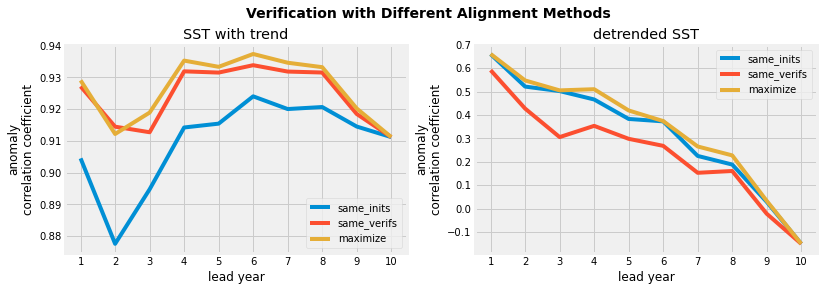

In [4]:
f, axs = plt.subplots(ncols=2, figsize=(12,4), sharex=True)
for alignment in ['same_inits', 'same_verifs', 'maximize']:
    hindcast.verify(metric='acc', alignment=alignment)['SST'] \
            .plot(label=alignment, ax=axs[0])
    hindcast_dt.verify(metric='acc', alignment=alignment)['SST'] \
               .plot(label=alignment, ax=axs[1])

axs[0].legend()
axs[1].legend()
axs[0].set(ylabel='anomaly\ncorrelation coefficient',
       xlabel='lead year',
       xticks=np.arange(1, 11),
       title='SST with trend')
axs[1].set(ylabel='anomaly\ncorrelation coefficient',
           xlabel='lead year',
           title='detrended SST')

f.suptitle('Verification with Different Alignment Methods',
           fontsize=14, weight='bold')
plt.subplots_adjust(top=0.85)

plt.show()

These alignment keywords also extend to `compute_persistence`, which uses the identical set of initializations (and alignment strategy) in its computation. Below, the dashed lines represent the persistence forecast for the given alignment strategy, while the solid lines denote the initialized anomaly correlation coefficient (as in the above plots).

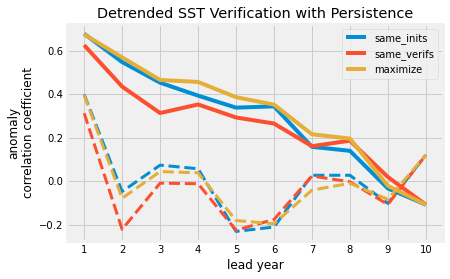

In [5]:
COLORS = ['#008FD5', '#FC4F30', '#E5AE38']
f, axs = plt.subplots()

for alignment, color in zip(['same_inits', 'same_verifs', 'maximize'], COLORS):
    result = hindcast_dt.verify(metric='acc', reference='persistence', alignment=alignment)
    result.sel(skill='init').SST.plot(label=alignment, color=color)
    result.sel(skill='persistence').SST.plot(linestyle='--', color=color, lw=3)
    

axs.set(ylabel='anomaly\ncorrelation coefficient',
        xlabel='lead year',
        xticks=np.arange(1, 11),
        title='Detrended SST Verification with Persistence')
plt.legend()
plt.show()

We'll be using the same example data as above. `climpred` will be aligning the following initialization and verification dates:

In [6]:
print(f'initialization dates: \n{hindcast.get_initialized().init.to_index()}')

initialization dates: 
CFTimeIndex([1954-01-01 00:00:00, 1955-01-01 00:00:00, 1956-01-01 00:00:00,
             1957-01-01 00:00:00, 1958-01-01 00:00:00, 1959-01-01 00:00:00,
             1960-01-01 00:00:00, 1961-01-01 00:00:00, 1962-01-01 00:00:00,
             1963-01-01 00:00:00, 1964-01-01 00:00:00, 1965-01-01 00:00:00,
             1966-01-01 00:00:00, 1967-01-01 00:00:00, 1968-01-01 00:00:00,
             1969-01-01 00:00:00, 1970-01-01 00:00:00, 1971-01-01 00:00:00,
             1972-01-01 00:00:00, 1973-01-01 00:00:00, 1974-01-01 00:00:00,
             1975-01-01 00:00:00, 1976-01-01 00:00:00, 1977-01-01 00:00:00,
             1978-01-01 00:00:00, 1979-01-01 00:00:00, 1980-01-01 00:00:00,
             1981-01-01 00:00:00, 1982-01-01 00:00:00, 1983-01-01 00:00:00,
             1984-01-01 00:00:00, 1985-01-01 00:00:00, 1986-01-01 00:00:00,
             1987-01-01 00:00:00, 1988-01-01 00:00:00, 1989-01-01 00:00:00,
             1990-01-01 00:00:00, 1991-01-01 00:00:00, 1992-01-01

In [7]:
print(f'verification dates: \n{hindcast.get_observations().time.to_index()}')

verification dates: 
CFTimeIndex([1955-01-01 00:00:00, 1956-01-01 00:00:00, 1957-01-01 00:00:00,
             1958-01-01 00:00:00, 1959-01-01 00:00:00, 1960-01-01 00:00:00,
             1961-01-01 00:00:00, 1962-01-01 00:00:00, 1963-01-01 00:00:00,
             1964-01-01 00:00:00, 1965-01-01 00:00:00, 1966-01-01 00:00:00,
             1967-01-01 00:00:00, 1968-01-01 00:00:00, 1969-01-01 00:00:00,
             1970-01-01 00:00:00, 1971-01-01 00:00:00, 1972-01-01 00:00:00,
             1973-01-01 00:00:00, 1974-01-01 00:00:00, 1975-01-01 00:00:00,
             1976-01-01 00:00:00, 1977-01-01 00:00:00, 1978-01-01 00:00:00,
             1979-01-01 00:00:00, 1980-01-01 00:00:00, 1981-01-01 00:00:00,
             1982-01-01 00:00:00, 1983-01-01 00:00:00, 1984-01-01 00:00:00,
             1985-01-01 00:00:00, 1986-01-01 00:00:00, 1987-01-01 00:00:00,
             1988-01-01 00:00:00, 1989-01-01 00:00:00, 1990-01-01 00:00:00,
             1991-01-01 00:00:00, 1992-01-01 00:00:00, 1993-01-01 0

We use the standard python library `logging` to log the initializations and verification dates used in alignment at each lead. The user can check these logs to ensure that the expected initializations and verification dates are being retained. See the logging section on this page for more details.

In [8]:
import logging
# Print log to screen with initializations and verification dates.
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Same Verification Dates

`alignment='same_verifs'` (**default**)

The `same_verifs` alignment finds a set of verification dates that can be verified against over all leads. It also requires that the verification data have an observation at each initialization being retained. This is so that the reference forecast, such as persistence, uses an identical set of initializations in deriving its forecast. Notice in the logger output that a common set of verification dates spanning 1965-2015 are used, while the initialization window slides one year at each lead.

**References**:

1. Boer, George J., et al. "The decadal climate prediction project (DCPP) contribution to CMIP6." Geoscientific Model Development (Online) 9.10 (2016). [https://doi.org/10.5194/gmd-9-3751-2016]
2. Hawkins, Ed, et al. "The interpretation and use of biases in decadal climate predictions." Journal of climate 27.8 (2014): 2931-2947. [https://doi.org/10.1175/JCLI-D-13-00473.1]
3. Smith, Doug M., Rosie Eade, and Holger Pohlmann. "A comparison of full-field and anomaly initialization for seasonal to decadal climate prediction." Climate dynamics 41.11-12 (2013): 3325-3338. [https://doi.org/10.1007/s00382-013-1683-2]

In [9]:
skill = hindcast.verify(alignment='same_verifs')

INFO:root:lead: 01 | inits: 1963-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 02 | inits: 1962-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 03 | inits: 1961-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 04 | inits: 1960-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 05 | inits: 1959-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 06 | inits: 1958-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 07 | inits: 1957-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 08 | inits: 1956-01-01 00:00:00-2007-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 09 | inits: 1955-01-01 00:00:00-2006-01-

Here, we include a figure of a simpler alignment case with annual initializations from 1990 through 2000 and three lead years. We verify this hypothetical initialized ensemble against a product that spans 1995 through 2002.

Two conditions must be met when selecting the verification window:


1. There must be a union between the initialization dates and verification dates. This
   is represented by the black vertical lines in the top panel below, which leave out
   1990-1994 initializations since there aren't observations before 1995. This logic
   exists so that any reference forecasts
   (e.g. a persistence forecast) use an identical set of initializations as the
   initialized forecast.
   
2. A given verification time must exist across all leads. This is to ensure that at each
   lead, the entire set of chosen verification dates can be verified against. This is
   represented by diagonals in the top panel below (and the dashed black lines).
   Without the first stipulation, this would set the verification window at 1995-2001.
   
This leaves us with a verification window of [1998, 1999, 2000, 2001] which can be verified against across all leads (and have a complimentary persistence forecast with the same set of initializations used at each lead).

![sameverifs](images/alignment_plots/same_verifs_alignment.png)

## Same Initializations

`alignment='same_inits'`

The `same_inits` alignment finds a set of initializations that can verify over all leads. It also requires that the verification data have an observation at each initialization being retained. This is so that the reference forecast, such as persistence, uses an identical set of initializations in deriving its forecast. Notice in the logger output that a common set of initializations spanning 1955-2005 are used, while the verification window slides one year at each lead.

In [10]:
skill = hindcast.verify(alignment='same_inits')

INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2006-01-01 00:00:00
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2007-01-01 00:00:00
INFO:root:lead: 03 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1957-01-01 00:00:00-2008-01-01 00:00:00
INFO:root:lead: 04 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1958-01-01 00:00:00-2009-01-01 00:00:00
INFO:root:lead: 05 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1959-01-01 00:00:00-2010-01-01 00:00:00
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2011-01-01 00:00:00
INFO:root:lead: 07 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1961-01-01 00:00:00-2012-01-01 00:00:00
INFO:root:lead: 08 | inits: 1954-01-01 00:00:00-2005-01-01 00:00:00 | verifs: 1962-01-01 00:00:00-2013-01-01 00:00:00
INFO:root:lead: 09 | inits: 1954-01-01 00:00:00-2005-01-

Here, we include a figure of a simpler alignment case with annual initializations from 1990 through 2000 and three lead years. We verify this hypothetical initialized ensemble against a product that spans 1995 through 2002.

Two conditions must be met to retain the initializations for verification: 

1. There must be an observation in the verification data for the given initialization.
   In combination with (1), initializations 1990 through 1994 are left out. This logic
   exists so that any reference forecast (e.g. a persistence forecast) use an identical set of initializations as the
   initialized forecast.

2. All forecasted times (i.e., initialization + lead year) for a given initialization
   must be contained in the verification data. Schematically, this means that there must
   be a union between a column in the top panel and the time series in the bottom panel.
   The 2000 initialization below is left out since the verification data does not
   contain 2003.
   
This leaves us with initializations [1995, 1996, ..., 1999] which can verify against the observations at all three lead years.

![sameinits](images/alignment_plots/same_inits_alignment.png)

## Maximize Degrees of Freedom

`alignment='maximize'`

The `maximize` alignment verifies against every available observation at each lead. This means that both the initializations and verification dates could be different at each lead.  It also requires that the verification data have an observation at each initialization being retained. This is so that the reference forecast, such as persistence, uses an identical set of initializations in deriving its forecast.

Notice in the logger output that the initialization window shrinks from 1955-2014 (N=60) at lead year 1 to 1955-2005 (N=51) at lead year 10. Similarly, the verification window spans 1956-2015 at lead year 1 and 1965-2015 at lead year 10. However, using the other two alignment strategies (`same_verifs` and `same_inits`), there is a fixed N=51 to ensure constant initializations or verification dates, while the number of samples is extended to as high as 60 with this alignment strategy.

**References**:

1. Yeager, S. G., et al. "Predicting near-term changes in the Earth System: A large ensemble of initialized decadal prediction simulations using the Community Earth System Model." Bulletin of the American Meteorological Society 99.9 (2018): 1867-1886. [https://doi.org/10.1175/BAMS-D-17-0098.1]

In [11]:
skill = hindcast.verify(alignment='maximize')

INFO:root:lead: 01 | inits: 1954-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1955-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 02 | inits: 1954-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 03 | inits: 1954-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1957-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 04 | inits: 1954-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1958-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 05 | inits: 1954-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1959-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 06 | inits: 1954-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1960-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 07 | inits: 1954-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1961-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 08 | inits: 1954-01-01 00:00:00-2007-01-01 00:00:00 | verifs: 1962-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 09 | inits: 1954-01-01 00:00:00-2006-01-

Here, we include a figure of a simpler alignment case with annual initializations from 1990 through 2000 and three lead years. We verify this hypothetical initialized ensemble against a product that spans 1995 through 2002.

Two conditions must be met when selecting initializations/verifications at each lead:
   
1. There must be a union between the initialization dates and verification dates. This
   is represented by the black vertical lines in the top panel below, which leave out
   1990-1994 initializations since there aren't observations before 1995. This logic
   exists so that any reference forecasts
   (e.g. a persistence forecast) use an identical set of initializations as the
   initialized forecast.
   
2. The selected initializations must verify with the provided observations for the given lead.
   This is shown by the hatching in the figure below. The 2000 initialization is left out
   at lead year 3 since there is no observation for 2003.

This leaves us with the following alignment:

* LY1 initializations: [1995, 1996, 1997, 1998, 1999, 2000]

* LY2 initializations: [1995, 1996, 1997, 1998, 1999, 2000]

* LY3 initializations: [1995, 1996, 1997, 1998, 1999]



![maximize](images/alignment_plots/maximize_alignment.png)

## Logging

``climpred`` uses the standard library ``logging`` to store the initializations and verification dates used at each lead for a given computation. This is used internally for testing, but more importantly, can be activated by the user so they can be sure of how computations are being done.

To see the log interactively, e.g. while working in Jupyter notebooks or on the command line use the following:

In [12]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [13]:
skill = hindcast.verify(alignment='same_verifs')

INFO:root:lead: 01 | inits: 1963-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 02 | inits: 1962-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 03 | inits: 1961-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 04 | inits: 1960-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 05 | inits: 1959-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 06 | inits: 1958-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 07 | inits: 1957-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 08 | inits: 1956-01-01 00:00:00-2007-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 09 | inits: 1955-01-01 00:00:00-2006-01-

The `INFO` level reports the minimum and maximum bounds for initializations and verification dates. To see every single initialization and verification date used, set the level to `DEBUG`.

In [14]:
logger.setLevel(logging.DEBUG)

In [15]:
skill = hindcast.isel(lead=slice(0, 2)).verify(alignment='same_verifs')

INFO:root:lead: 01 | inits: 1955-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1956-01-01 00:00:00-2015-01-01 00:00:00
DEBUG:root:
inits: ['1955-1-1', '1956-1-1', '1957-1-1', '1958-1-1', '1959-1-1', '1960-1-1', '1961-1-1', '1962-1-1', '1963-1-1', '1964-1-1', '1965-1-1', '1966-1-1', '1967-1-1', '1968-1-1', '1969-1-1', '1970-1-1', '1971-1-1', '1972-1-1', '1973-1-1', '1974-1-1', '1975-1-1', '1976-1-1', '1977-1-1', '1978-1-1', '1979-1-1', '1980-1-1', '1981-1-1', '1982-1-1', '1983-1-1', '1984-1-1', '1985-1-1', '1986-1-1', '1987-1-1', '1988-1-1', '1989-1-1', '1990-1-1', '1991-1-1', '1992-1-1', '1993-1-1', '1994-1-1', '1995-1-1', '1996-1-1', '1997-1-1', '1998-1-1', '1999-1-1', '2000-1-1', '2001-1-1', '2002-1-1', '2003-1-1', '2004-1-1', '2005-1-1', '2006-1-1', '2007-1-1', '2008-1-1', '2009-1-1', '2010-1-1', '2011-1-1', '2012-1-1', '2013-1-1', '2014-1-1']
verifs: ['1956-1-1', '1957-1-1', '1958-1-1', '1959-1-1', '1960-1-1', '1961-1-1', '1962-1-1', '1963-1-1', '1964-1-1', '1965-1-1', '1966-1-1', '

One can also save out the log to a file.

In [16]:
logger = logging.getLogger()
logger.setLevel(logging.INFO)
fh = logging.FileHandler('hindcast.out')
logger.addHandler(fh)

In [17]:
skill = hindcast.verify(alignment='same_verifs')

INFO:root:lead: 01 | inits: 1963-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 02 | inits: 1962-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 03 | inits: 1961-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 04 | inits: 1960-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 05 | inits: 1959-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 06 | inits: 1958-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 07 | inits: 1957-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 08 | inits: 1956-01-01 00:00:00-2007-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 09 | inits: 1955-01-01 00:00:00-2006-01-

In [18]:
skill = hindcast.verify(alignment='same_verifs')

INFO:root:lead: 01 | inits: 1963-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 02 | inits: 1962-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 03 | inits: 1961-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 04 | inits: 1960-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 05 | inits: 1959-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 06 | inits: 1958-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 07 | inits: 1957-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 08 | inits: 1956-01-01 00:00:00-2007-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
INFO:root:lead: 09 | inits: 1955-01-01 00:00:00-2006-01-

In [19]:
!cat hindcast.out

lead: 01 | inits: 1963-01-01 00:00:00-2014-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 02 | inits: 1962-01-01 00:00:00-2013-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 03 | inits: 1961-01-01 00:00:00-2012-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 04 | inits: 1960-01-01 00:00:00-2011-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 05 | inits: 1959-01-01 00:00:00-2010-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 06 | inits: 1958-01-01 00:00:00-2009-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 07 | inits: 1957-01-01 00:00:00-2008-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 08 | inits: 1956-01-01 00:00:00-2007-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 09 | inits: 1955-01-01 00:00:00-2006-01-01 00:00:00 | verifs: 1964-01-01 00:00:00-2015-01-01 00:00:00
lead: 10 | inits: 1954-01-01

In [20]:
!rm hindcast.out